<a href="https://colab.research.google.com/github/noviaputri/Multilabel_Text_Classification/blob/main/Klasifikasi_Teks_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Nama : Novia Putri

Proyek : Membuat Model NLP

In [ ]:
import pandas as pd
import io
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving bbc-text.csv to bbc-text.csv


In [ ]:
# menyimpan dataset dalam pandas dataframe
df = pd.read_csv(io.BytesIO(uploaded['bbc-text.csv']))
df

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...
...,...,...
2220,business,cars pull down us retail figures us retail sal...
2221,politics,kilroy unveils immigration policy ex-chatshow ...
2222,entertainment,rem announce new glasgow concert us band rem h...
2223,politics,how political squabbles snowball it s become c...


In [ ]:
# melihat nilai unik pada kolom kategori 
df['category'].unique()

array(['tech', 'business', 'sport', 'entertainment', 'politics'],
      dtype=object)

In [ ]:
# melihat info detail dari dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  2225 non-null   object
 1   text      2225 non-null   object
dtypes: object(2)
memory usage: 34.9+ KB


In [ ]:
# mengambil stopwords dari nltk corpus
stop_words = set(stopwords.words('english'))

# membuat fungsi untuk membersihkan dataset text
def cleaning(text):
    text = text.lower() # menjadikan text huruf kecil semua
    text = re.sub(r'\d+','', text) # menghapus angka
    text = re.sub(r'[^\w\s]', '', text) # menghapus punctuation
    text = re.sub('  +', ' ', text) # menghapus extra spaces
    text = ' '.join(['' if word in stop_words else word for word in text.split(' ')]) # menghapus stopwords
    return text

df['text']=df['text'].apply(cleaning)

In [ ]:
df['text'][10]

'berlin cheers  antinazi film  german movie   antinazi resistance heroine  drawn loud applause  berlin film festival sophie scholl  final days portrays  final days   member   white rose movement scholl  arrested  beheaded   brother hans   distributing leaflets condemning  abhorrent tyranny  adolf hitler director marc rothemund said    feeling  responsibility  keep  legacy   scholls going  must somehow keep  ideas alive  added  film drew  transcripts  gestapo interrogations  scholl  trial preserved   archive  communist east germany  secret police  discovery   inspiration behind  film  rothemund  worked closely  surviving relatives including one  scholl  sisters  ensure historical accuracy   film scholl   members   white rose resistance group first started distributing antinazi leaflets   summer    arrested   dropped leaflets  munich university calling   day  reckoning  adolf hitler  regime  film focuses   six days  scholl  arrest   intense trial  saw scholl initially deny  charges  ende

In [ ]:
# melakukan proses one-hot-encoding pada kolom kategori dan membuat dataframe baru
category = pd.get_dummies(df.category)
df_baru = pd.concat([df, category], axis=1)
df_baru = df_baru.drop(columns='category')
df_baru

,text,business,entertainment,politics,sport,tech
0,tv future hands viewers home theatre syste...,0,0,0,0,1
1,worldcom boss left books alone former worldcom...,1,0,0,0,0
2,tigers wary farrell gamble leicester say ...,0,0,0,1,0
3,yeading face newcastle fa cup premiership sid...,0,0,0,1,0
4,ocean twelve raids box office ocean twelve ...,0,1,0,0,0
...,...,...,...,...,...,...
2220,cars pull us retail figures us retail sales f...,1,0,0,0,0
2221,kilroy unveils immigration policy exchatshow h...,0,0,1,0,0
2222,rem announce new glasgow concert us band rem ...,0,1,0,0,0
2223,political squabbles snowball become commonp...,0,0,1,0,0


In [ ]:
# inisialisasi nilai text dan label ke dalam tipe data numpy array
text = df_baru['text'].values
label = df_baru[['business', 'entertainment', 'politics', 'sport', 'tech']].values

In [ ]:
# membagi data latih dan data test dengan proporsi 80:20
text_latih, text_test, label_latih, label_test = train_test_split(text, label, test_size=0.2, random_state = 42)

In [ ]:
# mengubah setiap kata pada dataset ke dalam bilangan numerik dengan fungsi Tokenizer
# lalu mengonversi setiap sampel menjadi sequence
tokenizer = Tokenizer(num_words=50000, oov_token='x', lower=True)
tokenizer.fit_on_texts(text_latih) 
tokenizer.fit_on_texts(text_test)
 
sekuens_latih = tokenizer.texts_to_sequences(text_latih)
sekuens_test = tokenizer.texts_to_sequences(text_test)
 
padded_latih = pad_sequences(sekuens_latih, maxlen=2500) 
padded_test = pad_sequences(sekuens_test, maxlen=2500)

In [ ]:
# membuat model LSTM
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=50000, output_dim=100,input_length=2500),
    tf.keras.layers.SpatialDropout1D(0.2),
    tf.keras.layers.LSTM(100),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')
])
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [ ]:
num_epochs = 15
history = model.fit(padded_latih, 
                    label_latih, 
                    epochs=num_epochs, 
                    batch_size= 64,
                    validation_data=(padded_test, label_test), 
                    verbose=2, 
                    callbacks=[tf.keras.callbacks.EarlyStopping(patience=3,
                                                                monitor='val_loss',
                                                                restore_best_weights=True,
                                                                mode='min',
                                                                verbose=1)])

Epoch 1/15
28/28 - 73s - loss: 1.5895 - accuracy: 0.2455 - val_loss: 1.5465 - val_accuracy: 0.2337
Epoch 2/15
28/28 - 69s - loss: 1.3398 - accuracy: 0.4961 - val_loss: 1.1163 - val_accuracy: 0.4494
Epoch 3/15
28/28 - 69s - loss: 0.6936 - accuracy: 0.7275 - val_loss: 0.5830 - val_accuracy: 0.8202
Epoch 4/15
28/28 - 68s - loss: 0.3272 - accuracy: 0.9298 - val_loss: 0.4238 - val_accuracy: 0.8921
Epoch 5/15
28/28 - 69s - loss: 0.1323 - accuracy: 0.9736 - val_loss: 0.3654 - val_accuracy: 0.9079
Epoch 6/15
28/28 - 68s - loss: 0.0369 - accuracy: 0.9955 - val_loss: 0.2896 - val_accuracy: 0.9191
Epoch 7/15
28/28 - 69s - loss: 0.0244 - accuracy: 0.9944 - val_loss: 0.2567 - val_accuracy: 0.9281
Epoch 8/15
28/28 - 68s - loss: 0.0201 - accuracy: 0.9972 - val_loss: 0.2633 - val_accuracy: 0.9371
Epoch 9/15
28/28 - 68s - loss: 0.0129 - accuracy: 0.9983 - val_loss: 0.4124 - val_accuracy: 0.8944
Epoch 10/15
28/28 - 68s - loss: 0.0102 - accuracy: 1.0000 - val_loss: 0.3184 - val_accuracy: 0.9326
Restoring

In [ ]:
# menampilkan nilai loss dan akurasi model
acc = model.evaluate(padded_test, label_test)
print('Loss: {:0.3f} \nAccuracy: {:0.3f}'.format(acc[0],acc[1]))

14/14 [==============================] - 5s 324ms/step - loss: 0.2567 - accuracy: 0.9281
Loss: 0.257 
Accuracy: 0.928


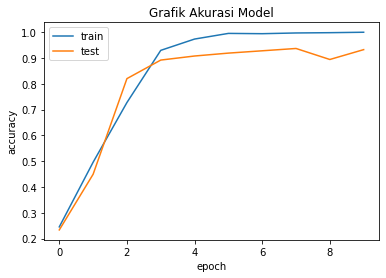

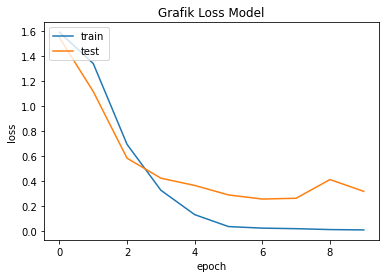

In [ ]:
# plotting nilai loss dan akurasi model berdasarkan history pada proses pelatihan model
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('Grafik Akurasi Model')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Grafik Loss Model')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()